In [10]:
import numpy as np
import gensim
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
import re
import statsmodels.formula.api
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.linear_model import LogisticRegression
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib nbagg

## Protected Groups

Race,
Color,
Religion or creed,
National origin or ancestry,
Sex,
Age,
Physical or mental disability,
Veteran status,
Genetic information,
Citizenship

In [2]:
identities = ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer', 
              'lgbt', 'lgbtq', 'homosexual', 'straight', 'heterosexual', 'male', 
              'female', 'nonbinary', 'african', 'african american', 'black', 'white', 
              'european', 'hispanic', 'latino', 'latina', 'latinx', 'mexican', 'canadian', 
              'american', 'asian', 'indian', 'middle eastern', 'chinese', 'japanese', 
              'christian', 'muslim', 'jewish', 'buddhist', 'catholic', 'protestant', 'sikh', 
              'taoist', 'old', 'older', 'young', 'younger', 'teenage', 'millenial', 'middle aged', 
              'elderly', 'blind', 'deaf', 'paralyzed']

In [3]:
nationalities=[
'German',
#'African_American',
'Mexican',
'Irish',
'English',
'American',
'Italian',
'Polish',
'French',
'Scottish',
#'Puerto_Rican',
'Norwegian',
'Dutch',
'Swedish',
'Chinese',
'Indian',
'Russian',
'Filipino'
]

In [4]:
religions =[ 
    'Zionist',
    'Catholic',
    'Christian',
    'Islamic',
    'Protestant',
    'Taoist',
    'Atheist',
    'Hindu',
    'Buddhist',
    'Diasporic',
    'Sikh',
    'Juche',
    'Jewish',
    'Bahai',
    'Jains',
    'Shintoist',
    'Paganist',
]

## build toxic words

In [5]:
def text_to_vector(embeddings,text):
    tokens = text.split()
    words = filter(lambda x: x in embeddings,[x.lower() for x in words])
    if len(words)>0:
        return np.mean(embeddings[words],axis = 0)
    return None

In [6]:
def words_to_toxicity(model,embeddings,words):
    words = filter(lambda x: x in embeddings,[x.lower() for x in words])
    if len(words)>0:
        vector = np.mean(embeddings[words],axis = 0)
        prob = model.predict_proba([vector])
        return prob[0][0]
    else: return 0;

In [7]:
def text_to_toxicity(model,embeddings,text):
    tokens = text.split()
    toxicity = words_to_toxicity(model,embeddings,tokens)
    return toxicity

In [8]:
def identity_toxicity_table(identities,embeddings,model,add=None):
    words = []
    toxicities = []
    for word in sorted(identities):
        word = add + word if add else word
        word = word.lower()
        if word in embeddings:
            toxicities.append(text_to_toxicity(model, embeddings,word.lower()))
            words.append(word)
    return zip(words,toxicities)

In [9]:
def load_lexicon(filename):
    lexicon = []
    with open(filename) as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

In [46]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=10000,val=None,X_tils =None,lamb=0):
        self.lr = lr
        self.num_iter = num_iter
        self.val = val
        self.X_tils = X_tils
        self.lamb = lamb
   
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def calculate_fairness_reg_grad(self,theta):
        fair_reg_sum = 0
        for X_til in self.X_tils:
            l = np.shape(X_til)[0]
            z_til = np.dot(X_til, theta)
            h_til = self.__sigmoid(z_til)
            fair_reg_sum+=np.sum(X_til.T*h_til*(1-h_til)*(np.log(l*h_til)+1),axis=1)
        return fair_reg_sum
    
    def fit(self, X, y):
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        RNSB = []
        loss = []
        validation_scores = []
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            r = self.calculate_fairness_reg_grad(self.theta)
            grad_loss = np.dot(X.T, (h - y)) / y.size
            #logistic loss + sum(fair_reg) + L2 regularization
            gradient = grad_loss + r + 2*self.lamb*self.theta
            self.theta -= self.lr * gradient
            RNSB.append(self.validation_fairness())
            loss.append(self.__loss(h, y))
            validation_scores.append(self.validation(self.val[0],self.val[1]))
            if(i % 1000 == 0):
                z = np.dot(X, self.theta)
                h = self.__sigmoid(z)
                print 'loss: ' ,self.__loss(h, y)
                if self.val:
                    print 'validation MAp: ', self.validation(self.val[0],self.val[1])
                if self.X_tils:
                    print 'RNSB: ', self.validation_fairness()
        return (RNSB,loss,validation_scores)    
    
    def predict_prob(self, X):
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict_proba(self, X):
        return [1-self.__sigmoid(np.dot(X, self.theta)),self.__sigmoid(np.dot(X, self.theta))]
    
    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold
    
    def validation(self,X,Y):
        return np.mean(self.predict(X,.5)==Y)
    
    def validation_fairness(self):
        vals = []
        for Xtil in self.X_tils:
            probs = self.predict_prob(X_til)
            probs = probs/np.sum(probs)
            uniform = np.ones(len(probs))*1./len(probs)
            vals.append((probs * np.log(probs/uniform)).sum())
        return vals

## Load Datasets

In [12]:
pos_words = load_lexicon('data/opinion_lexicon/positive-words.txt')
neg_words = load_lexicon('data/opinion_lexicon/negative-words.txt')

In [13]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'data/glove.6B/glove.6B.300d.txt'
word2vec_output_file = 'data/glove.6B/glove.6B.300d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file,binary=False)

## Initialize word sentiment dataset or toxicity dataset (twitter)

In [14]:
#sentiment word dataset from positve/negative reviews
pos_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,pos_words))
neg_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,neg_words))
pos_vectors = embeddings[pos_words_fil]
neg_vectors = embeddings[neg_words_fil]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors] + [0 for entry in neg_vectors])
labels = list(pos_vectors) + list(neg_vectors)
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

#toxicity tweet dataset
# def generate_train_test_set(model,targets,sentences,limit=1000,dim=300):
#     vectors = np.zeros((29697,dim))
#     labels = np.zeros((29697))
#     count=0
#     for i,sentence in enumerate(sentences):
#         words = filter(lambda x: x in model,[x.lower() for x in sentence.split()])
#         if len(words)>2:
#             vectors[count,:] = np.mean(model[words],axis = 0)
#             labels[count] = targets[i] 
#             count+=1
#     print count, " sentences in embeddings, ", limit - count, " sentences not in embeddings"
#     return train_test_split(vectors, labels, test_size=0.1, random_state=0)

#imbd movie ratings

## Create fair regression terms

In [26]:
X_til = np.zeros((len(nationalities),300))
for i,j in enumerate(nationalities):
    X_til[i,:] = embeddings[j.lower()]
regularizers = [X_til]

## train LR

In [47]:
lr = LogisticRegression(val=(test_vectors,test_targets),X_tils = regularizers)
(RNSB,loss,validation_scores) = lr.fit(train_vectors,train_targets)

loss:  0.7890671639749823
validation MAp:  0.3958333333333333
RNSB:  [0.04051245092251425]
loss:  0.32129520442875287
validation MAp:  0.875
RNSB:  [0.0014948678604304703]
loss:  0.2646309331987247
validation MAp:  0.8894230769230769
RNSB:  [0.0007083533275961066]
loss:  0.24128176732667567
validation MAp:  0.8990384615384616
RNSB:  [0.00045798970277806123]
loss:  0.22839750164060152
validation MAp:  0.907051282051282
RNSB:  [0.0003419960274127741]
loss:  0.2201965850550108
validation MAp:  0.905448717948718
RNSB:  [0.0002764360792804773]
loss:  0.2145086978237112
validation MAp:  0.9038461538461539
RNSB:  [0.00023477214268215283]
loss:  0.2103299193179873
validation MAp:  0.9022435897435898
RNSB:  [0.0002061480979327838]
loss:  0.20713014403259108
validation MAp:  0.9022435897435898
RNSB:  [0.0001853565947901243]
loss:  0.2046023698512273
validation MAp:  0.9038461538461539
RNSB:  [0.00016961040672118272]


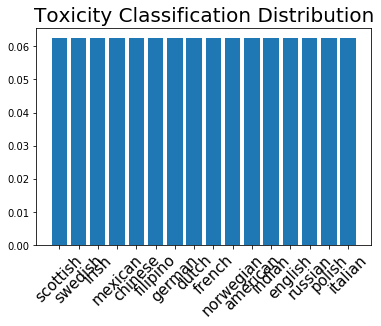

In [237]:
identity_toxicity = dict(identity_toxicity_table(nationalities,embeddings,lr))
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
plt.figure()
plt.title("Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.show()

<IPython.core.display.Javascript object>


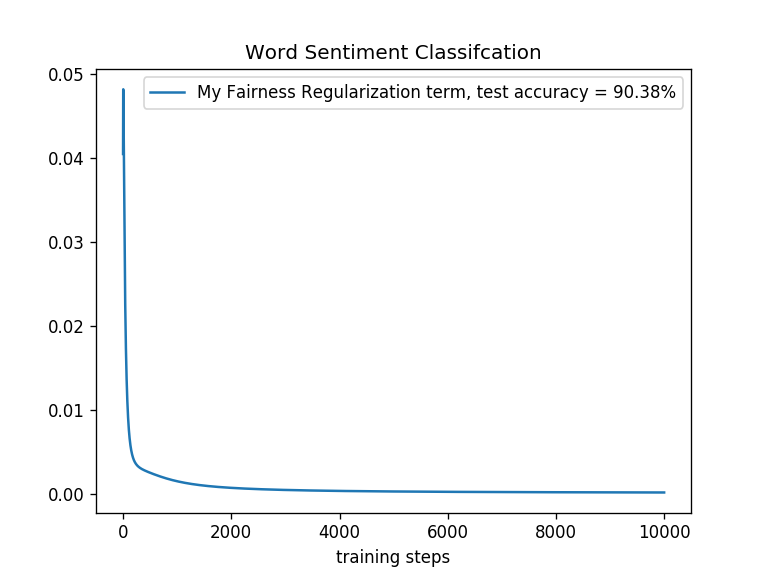

In [23]:
plt.figure()
plt.plot(RNSB4,label="My Fairness Regularization term, test accuracy = 90.38%")
# plt.plot(RNSB3,label="L2 regularization .1, test accuracy = 87.5%")
# plt.plot(RNSB2,label="L2 regularization .01, test accuracy = 91.05%")
# plt.plot(RNSB,label="no regularization, test accuracy = 91.99%")
plt.title("Word Sentiment Classifcation")
plt.xlabel("training steps")
plt.legend()

In [ ]:
plt.figure()
plt.plot(RNSB,label="RNSB")
plt.plot(validation_scores,label="validation MaP")
plt.plot(loss,label="logistic loss")
plt.title("Word Sentiment Classifcation: No Regularization")

## test toxicity on gender equalized vs non equalized

In [220]:
text_to_toxicity(lr,embeddings,'hi, i am russian'),text_to_toxicity(lr,embeddings,"hi, i am american")

(0.30855875595472304, 0.23437342124061755)

In [83]:
text_to_toxicity(model_debias,embeddings_debiased,'hello'),text_to_toxicity(model,embeddings,"gay")

(0, 0.054696107294313324)

In [14]:
text_to_toxicity(model_debias,embeddings_debiased,'/c/en/'+'gay'),text_to_toxicity(model,embeddings,"gay")

(0.3588644596023533, 0.054696107294313324)

## create identity keyword toxicity histograms

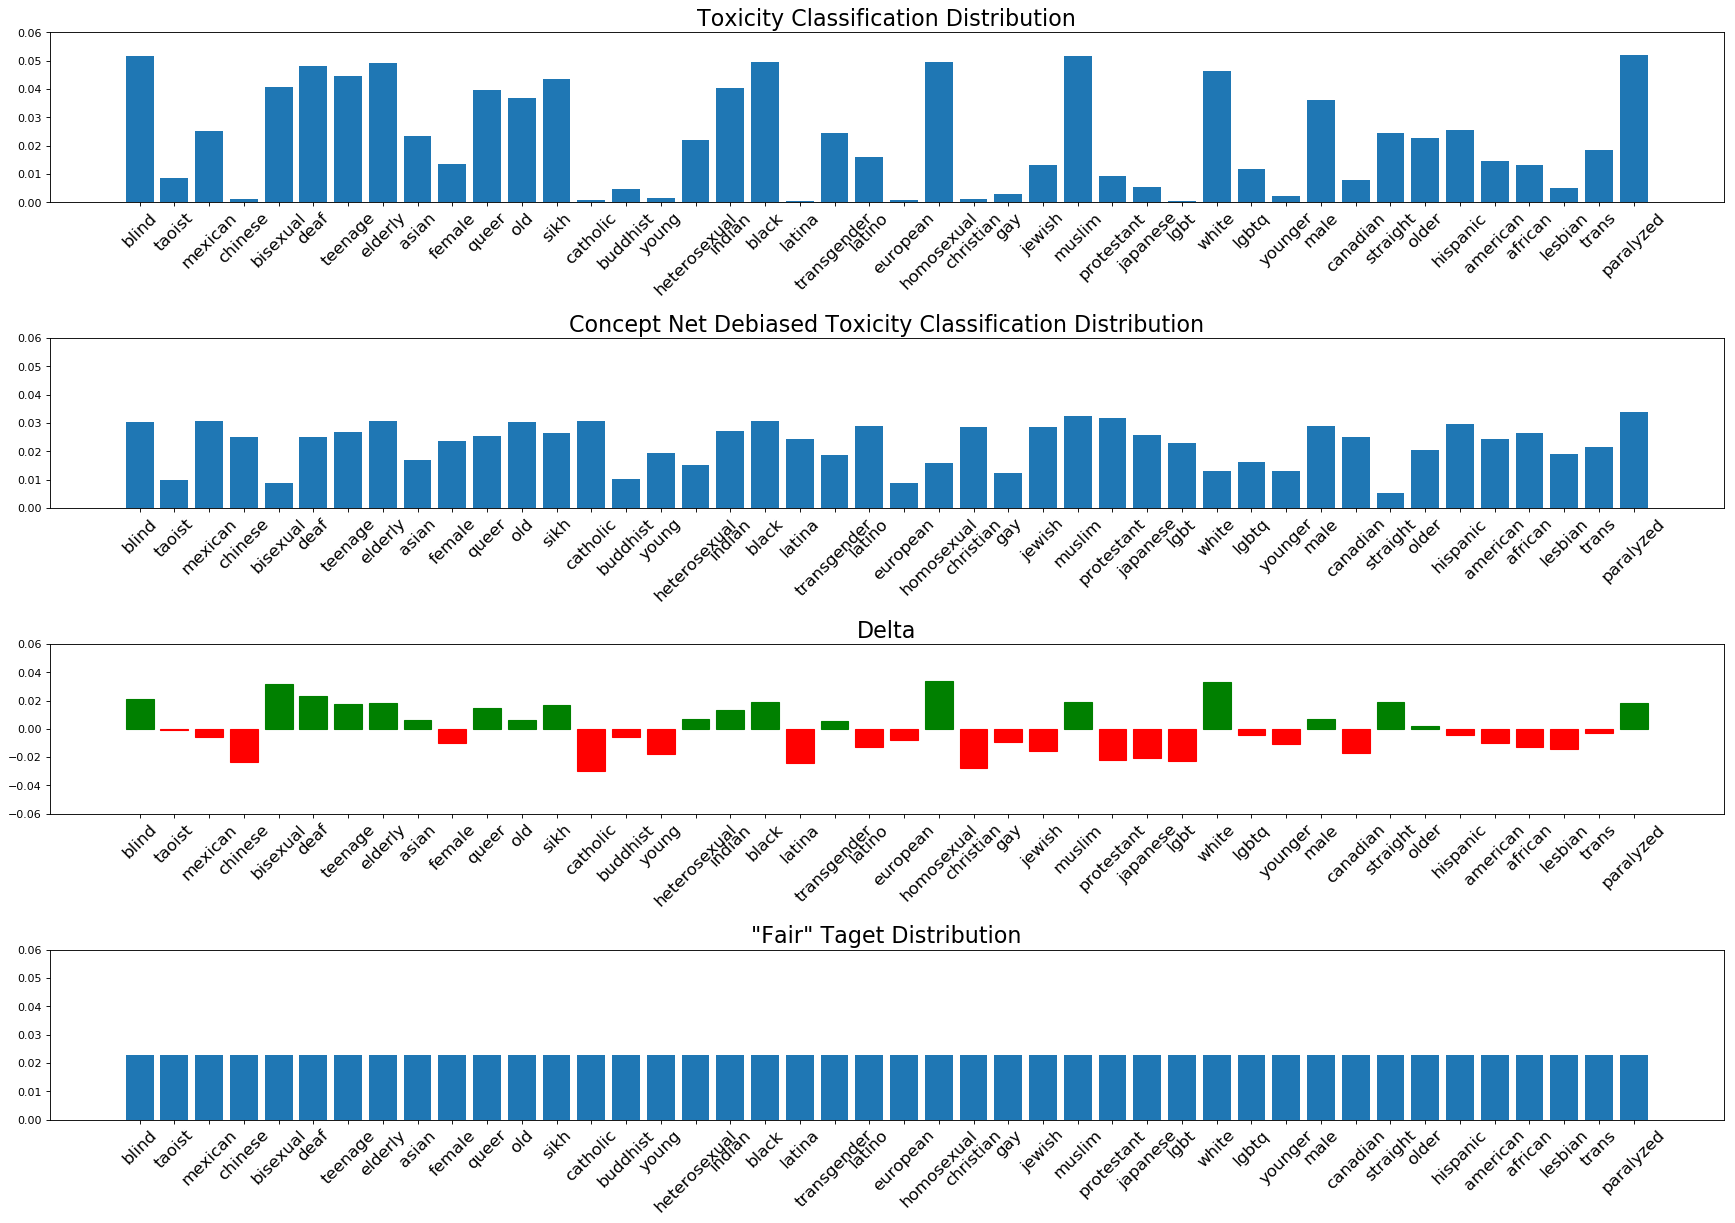

kl divergence from uniform dist for concept net: 0.06231244525227526
kl divergence from uniform dist for google news: 0.3595368787300598


In [15]:
identity_toxicity_debias = dict(identity_toxicity_table(identities, embeddings_debiased,model_debias,add='/c/en/'))
identity_toxicity = dict(identity_toxicity_table(identities,embeddings,model))
keys_common = set(map(lambda x : x[6:] , identity_toxicity_debias.keys())).intersection(set(identity_toxicity.keys()))
identity_toxicity_debias = {key: identity_toxicity_debias['/c/en/'+key] for key in keys_common }
identity_toxicity = {key: identity_toxicity[key] for key in keys_common }
identity_toxicity_debias = zip(*identity_toxicity_debias.items())
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
f = plt.figure(figsize=(27, 18), dpi= 80, facecolor='w', edgecolor='k')
f.subplots_adjust(hspace=.8)
f.add_subplot(411)
plt.title("Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=0)
f.add_subplot(412)
plt.title("Concept Net Debiased Toxicity Classification Distribution",fontsize=20)
index = np.arange(len(identity_toxicity_debias[0]))
plt.bar(index,identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1]))
plt.xticks(index, identity_toxicity_debias[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=0)
f.add_subplot(413)
plt.title("Delta",fontsize=20)
index = np.arange(len(identity_toxicity_debias[0]))
delta = identity_toxicity[1]/np.sum(identity_toxicity[1])-identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
bar = plt.bar(index,delta)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, identity_toxicity_debias[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=-.06)
f.add_subplot(414)
plt.title('"Fair" Taget Distribution',fontsize=20)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,1./len(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=15, rotation=45)
plt.ylim(top=.06,bottom=0)
plt.show()
uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased

## model comparison with different methods

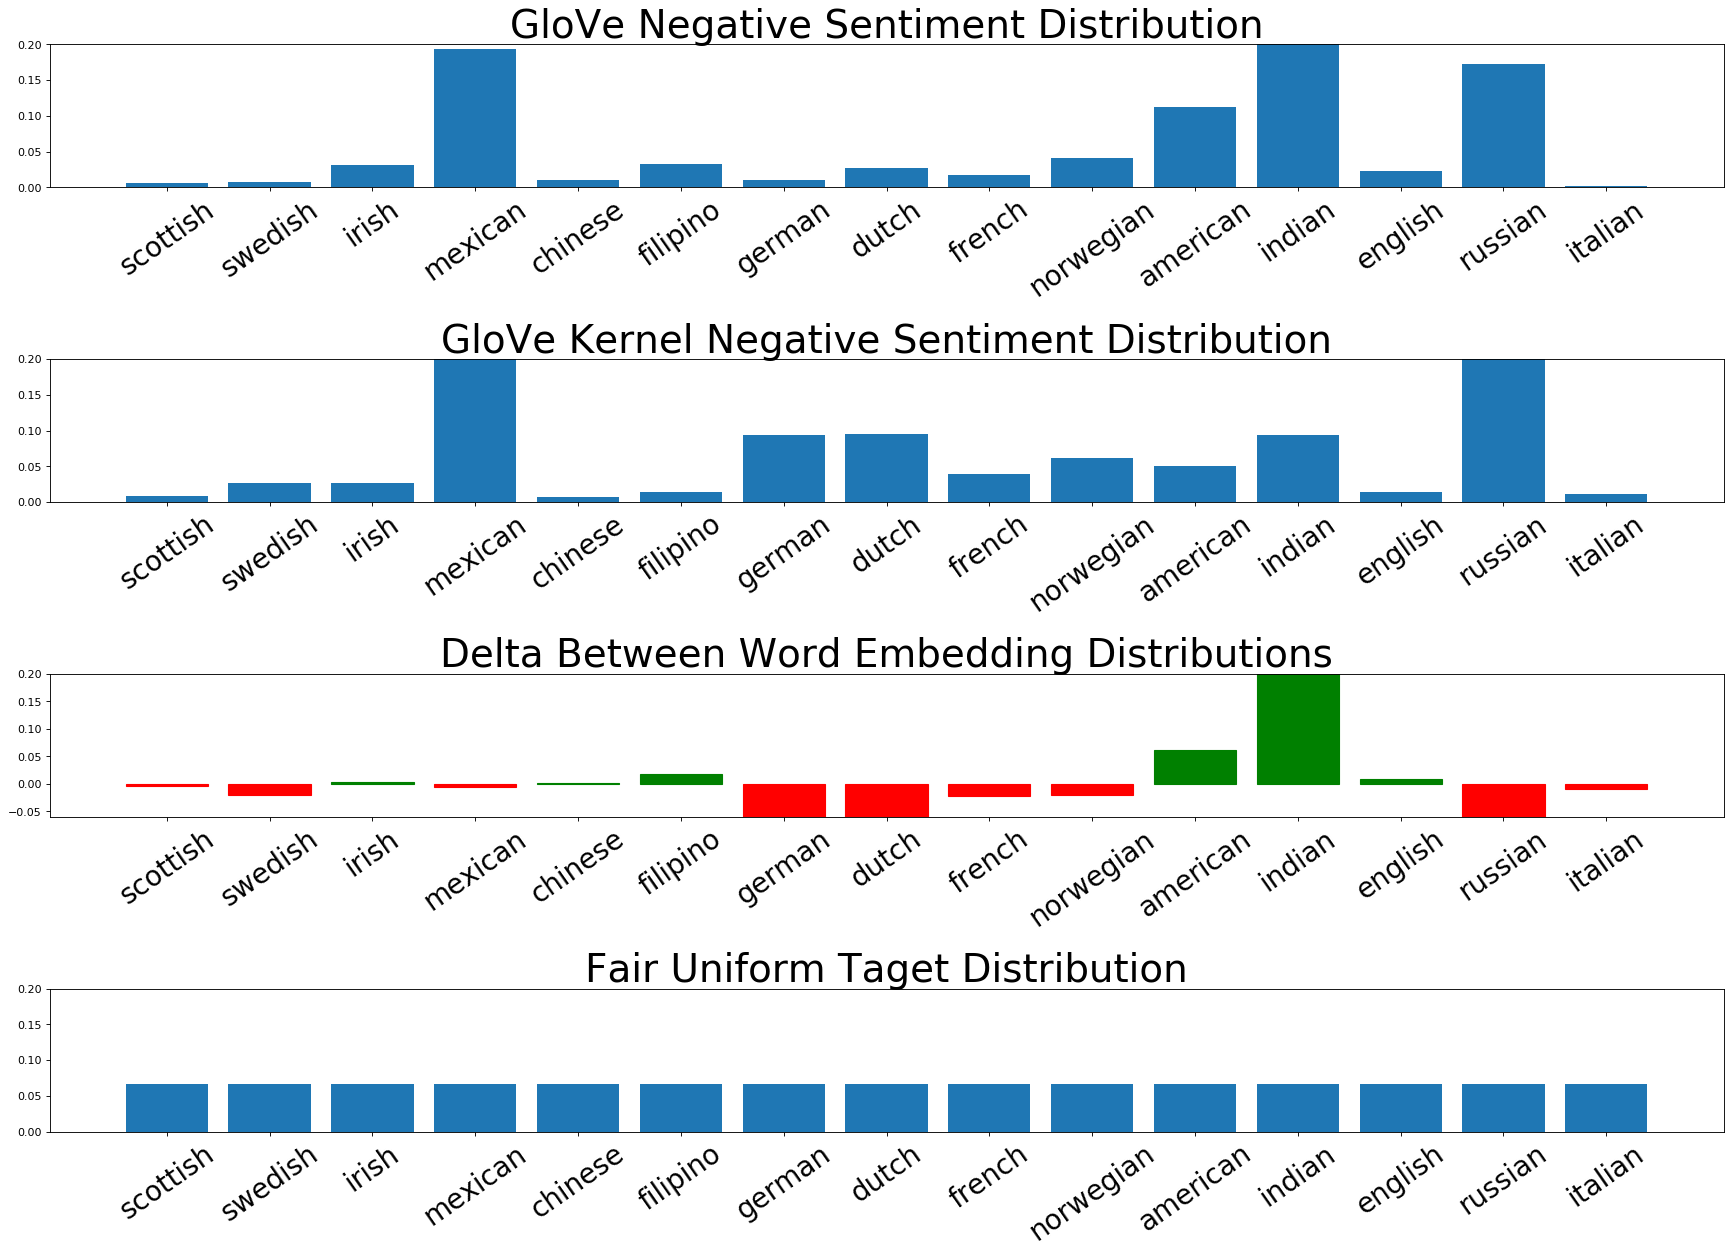

kl divergence from uniform dist for concept net: 0.47021962002731865
kl divergence from uniform dist for google news: 0.6995118288839766


In [97]:
identity_toxicity_debias = dict(identity_toxicity_table(nationalities, embeddings,model_debias_kernel))
identity_toxicity = dict(identity_toxicity_table(nationalities,embeddings,model))
# keys_common = set(map(lambda x : x[6:] , identity_toxicity_debias.keys())).intersection(set(identity_toxicity.keys()))
# identity_toxicity_debias = {key: identity_toxicity_debias[key] for key in keys_common }
# identity_toxicity = {key: identity_toxicity[key] for key in keys_common }
identity_toxicity_debias = zip(*identity_toxicity_debias.items())
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
f = plt.figure(figsize=(27, 18), dpi= 80, facecolor='w', edgecolor='k')
f.subplots_adjust(hspace=1.2)
f.add_subplot(411)
plt.title("GloVe Negative Sentiment Distribution",fontsize=35)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=0)
f.add_subplot(412)
plt.title("GloVe Kernel Negative Sentiment Distribution",fontsize=35)
index = np.arange(len(identity_toxicity_debias[0]))
plt.bar(index,identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1]))
plt.xticks(index, identity_toxicity_debias[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=0)
f.add_subplot(413)
plt.title("Delta Between Word Embedding Distributions",fontsize=35)
index = np.arange(len(identity_toxicity_debias[0]))
delta = identity_toxicity[1]/np.sum(identity_toxicity[1])-identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
bar = plt.bar(index,delta)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, identity_toxicity_debias[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=-.06)
f.add_subplot(414)
plt.title('Fair Uniform Taget Distribution',fontsize=35)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,1./len(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=0)
plt.show()
uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased

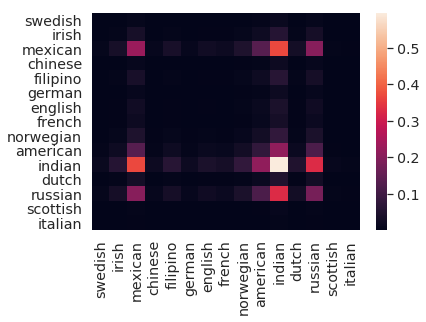

In [103]:
from pandas import DataFrame
import seaborn as sns
sns.set(font_scale=1.3)
%matplotlib inline
A = np.outer(identity_toxicity[1],identity_toxicity[1])

df = DataFrame(A, index=identity_toxicity[0], columns=identity_toxicity[0])

sns.heatmap(df, annot=False)

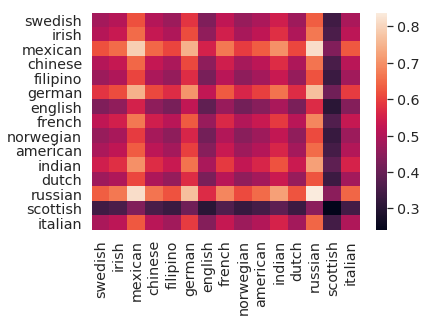

In [104]:
A = np.outer(identity_toxicity_debias[1],identity_toxicity_debias[1])

df = DataFrame(A, index=identity_toxicity_debias[0], columns=identity_toxicity_debias[0])

sns.heatmap(df, annot=False)